<a href="https://colab.research.google.com/github/Bennath-coder/Bennath-coder/blob/main/S5_002T_a%CC%80_004T_DL_NLP_vNPz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importation des packages et du dataset

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud

import re
import nltk
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay

%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df = pd.read_csv("S5_002_004_text.csv", index_col=0)
df = df.dropna()
df = df[df["review"].apply(lambda x: len(x)) > 2]
df.head()

,label,review
0,neg,how do films like mouse hunt get into theatres...
1,neg,some talented actresses are blessed with a dem...
2,pos,this has been an extraordinary year for austra...
3,pos,according to hollywood movies made in last few...
4,neg,my first press screening of 1998 and already i...


Ce dataset présente des critiques de films et la classe associée selon leur caractère positif (`pos`) ou négatif (`neg`). Nous allons tenter de construire un modèle pour classifier les critiques.

*Le dataset est disponible à cette adresse : https://www.kaggle.com/datasets/mammadabbasli/positiveornegative*

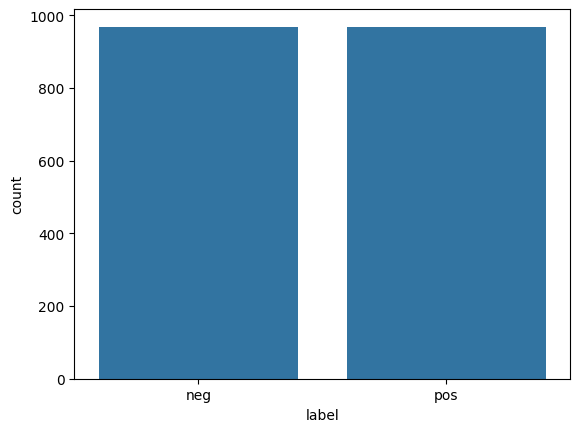

In [ ]:
sns.countplot(data=df, x="label")
plt.show()

On remarque en premier lieu que les dataset est bien équilbré entre les deux classes.

# Text embedding

## Nettoyage du texte

La première étape consiste à nettoyer les critiques en retirant la ponctuation et en éliminant les mots les plus courants (*stopwords*).

In [ ]:
stopword = nltk.corpus.stopwords.words('english')
def text_cleaning(text):
    text = re.sub(r'[^\w\s]', '',str(text)) # permet de récupérer les données sans les caractères spéciaux
    text = re.split("\W+",text) # permet de récupérer les données sans les ponctuations
    text = [word for word in text if word not in stopword]
    text = ' '.join(text)
    return text

In [ ]:
df["review"] = df["review"].apply(lambda x :text_cleaning(x)) # fonction 'lambda x' qui permet de nettoyer le texte à la colonne 'review'
df

,label,review
0,neg,films like mouse hunt get theatres isnt law so...
1,neg,talented actresses blessed demonstrated wide a...
2,pos,extraordinary year australian films shine scoo...
3,pos,according hollywood movies made last decades l...
4,neg,first press screening 1998 already ive gotten ...
...,...,...
1995,pos,like movies albert brooks really like movies d...
1996,pos,might surprise know joel ethan coen brought un...
1997,pos,verdict spinechilling drama horror maestro ste...
1998,pos,want correct wrote former retrospective david ...


## TF-IDF et Wordcloud

Avant de nous lancer dans le modèle de classification, analysons plus amplement les critiques positives et négatives.

A partir des critiques nettoyées, nous allons pouvoir vectoriser chaque texte via l'algorithme TF-IDF. Chaque mot est associé à une dimension et la valeur associée à chaque mot correspond au poids donné par la formule suivante :

$$TFIDF_{i,j} = tf_{i,j} \times \log \frac{N}{ndf_i}$$

avec :
* $tf_{i,j}$ : fréquence du mot $i$ dans la critique $j$,
* $N$ : nombre de critiques,
* $ndf_i$ : nombre de critiques comportant le mot $i$.

Regroupons les critiques positives d'un côté et les critiques négatives de l'autre, puis vectorisons les deux documents par TF-IDF :

In [ ]:
pos_reviews = ' '.join(df[df["label"] == "pos"]["review"].tolist()) # création d'un label avis positifs pour filtrer tout simplement les avis positifs
neg_reviews = ' '.join(df[df["label"] == "neg"]["review"].tolist()) # création d'un label avis négatifs pour filtrer tout simplement les avis négatifs

#on ajoute dans le vectorizer quelques mots spécifiques du cinéma qui ne seront pas utiles à notre analyse
tfidf = TfidfVectorizer(stop_words=["film", "films", "movie", "movies", "one", "two", "character", "characters", "time", "even"]) # je défini mon TF-IDF et je vais spécifier un certain nombre de 'stop_words' propres à l'industrie du cinéma pour ne pas altérer l'analyse
wc_tfidf = tfidf.fit_transform([pos_reviews, neg_reviews]) # j'entraîne mon modèle càd calculer les valeurs pour mes deux labels avis positifs et avis négatifs

In [ ]:
wc_tfidf

<2x46591 sparse matrix of type '<class 'numpy.float64'>'
	with 66064 stored elements in Compressed Sparse Row format>

L'attribut `vocabulary_` nous donne accès à l'index de chaque mot dans les vecteurs issus du TF-IDF :

In [ ]:
len(tfidf.vocabulary_) # j'ai 46591 mots (c'est comme si j'avais un dataframe de 46591 dimensions càd 46591 colonnes et avec deux lignes pour mes deux labels)

46591

In [ ]:
tfidf.vocabulary_ # je peux maintenant regarder comment est composé mon vocabulaire

{'extraordinary': 14527,
 'year': 46279,
 'australian': 3290,
 'shine': 37153,
 'scooped': 36076,
 'pool': 31396,
 'institute': 21221,
 'awards': 3412,
 'picking': 30804,
 'best': 4429,
 'actor': 1245,
 'director': 11456,
 'etc': 13937,
 'add': 1298,
 'gritty': 17870,
 'life': 23847,
 'anguish': 2295,
 'courage': 9375,
 'friendship': 16312,
 'group': 17935,
 'male': 24913,
 'prisoners': 32082,
 'hivpositive': 19417,
 'section': 36361,
 'jail': 21794,
 'love': 24418,
 'catastrophes': 6778,
 'low': 24457,
 'budget': 5868,
 'gem': 16856,
 'straight': 39679,
 'gay': 16801,
 'near': 27597,
 'university': 43659,
 'campus': 6380,
 'cant': 6448,
 'recall': 33430,
 'rich': 34656,
 'varied': 44222,
 'celluloid': 6923,
 'library': 23821,
 'unleashed': 43675,
 'australia': 3289,
 'bookend': 5159,
 'stand': 39240,
 'dead': 10375,
 'heart': 18837,
 'opening': 29068,
 'credits': 9584,
 'theme': 41458,
 'division': 11894,
 'established': 13909,
 'cast': 6732,
 'clear': 7770,
 'distinct': 11809,
 'line

On peut désormais regrouper dans un même DataFrame les mots et leurs poids respectifs dans les critiques positives et négatives :

In [ ]:
total_words = pd.DataFrame(tfidf.vocabulary_.keys(), index=tfidf.vocabulary_.values(), columns=["word"]).sort_index()
total_words[["pos", "neg"]] = np.array(wc_tfidf.todense().T)
total_words.head()

,word,pos,neg
0,00,0.000267,0.000574
1,000,0.007076,0.008177
2,0009f,0.000188,0.000000
3,000acre,0.000000,0.000202
4,000aweek,0.000375,0.000000


In [ ]:
total_words.sample(5, random_state=42) # je peux récupérer les mots dans un dataframe

,word,pos,neg
38167,smocky,0.000188,0.000000
14192,excises,0.000000,0.000202
4630,binds,0.000401,0.000143
29064,opened,0.003204,0.002152
18804,headquarters,0.000668,0.000574


Nous pouvons maintenant tracer le wordcloud associé aux critiques positives :

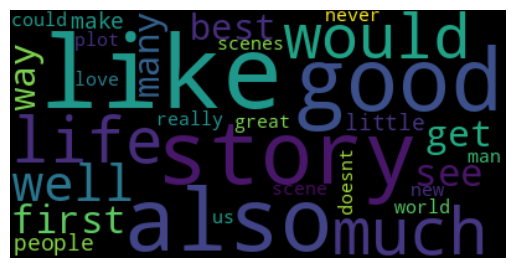

In [ ]:
wc = WordCloud()
wordcloud = wc.generate_from_frequencies(total_words[["word", "pos"]].sort_values(by="pos", ascending=False).head(30).set_index("word").to_dict()["pos"])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
# plus le mot est gros plus est il significatif dans le dataset

On retrouve des termes plutôt orientés : *like, good, much, well, best*. Nous pouvons faire la même opération sur les critiques négatives :

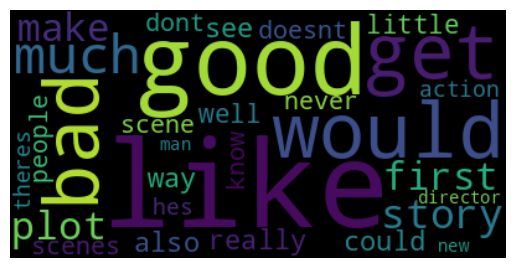

In [ ]:
wc = WordCloud()
wordcloud = wc.generate_from_frequencies(total_words[["word", "neg"]].sort_values(by="neg", ascending=False).head(30).set_index("word").to_dict()["neg"])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Nous retrouvons de même *good* et *like* car ces termes sont probablement présents sous la forme *not good* ou *don't like* dans ces critiques. On retrouve aussi les termes *bad*, *don't* et *doesn't* associés à des sentiments négatifs.

# Sentiment analysis

In [ ]:
X = df["review"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Commençons par entraîner l'algorithme TF-IDF sur les données issues du dataset d'entraînement :

In [ ]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train) #fit_transform : on entraîne le modèle et on récupère les vecteurs traduisant le dataset d'entraînement
X_test_tfidf = tfidf.transform(X_test) #transform : on récupère les vecteurs traduisant le dataset de test avec l'entraînement précédent

Pour prédire les classes `pos` et `neg`, nous allons utiliser une régression logistique à partir des vecteurs issus de la méthode précédente.

In [ ]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_tfidf,y_train)
y_pred = log_reg.predict(X_test_tfidf)

Nous pouvons tracer la matrice de confusion associée aux prédictions ...

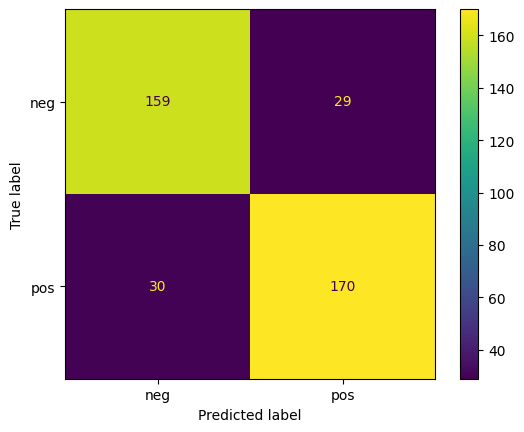

In [ ]:
ConfusionMatrixDisplay.from_estimator(log_reg,X_test_tfidf, y_test)
plt.show()

... calculer les métriques qui nous intéressent ...

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         neg       0.84      0.85      0.84       188
         pos       0.85      0.85      0.85       200

    accuracy                           0.85       388
   macro avg       0.85      0.85      0.85       388
weighted avg       0.85      0.85      0.85       388



... et tracer la ROC curve :

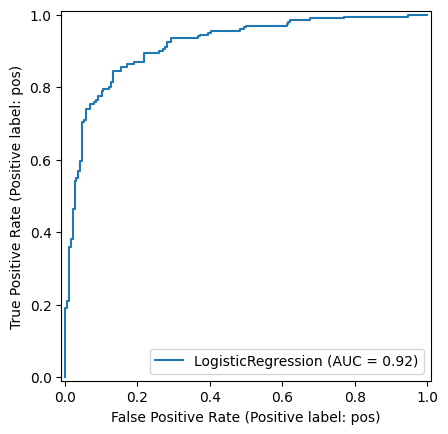

In [ ]:
RocCurveDisplay.from_estimator(log_reg, X_test_tfidf, y_test)
plt.show()

Avec un F1-score égal à 0.85 et une AUC égale à 0.92, nous obtenons des prédictions tout à fait convenables !

*Bonus : comparer les résultats obtenus avec une régression logistique et avec d'autres modèles de classification.*